<a href="https://colab.research.google.com/github/zhuchunlin1995/Deep-Learning/blob/master/pytorch_cnn_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This part uses Google Colab and the link is:
# https://colab.research.google.com/drive/1NSgEyUrCFoxeN6BUZT7RZws6gJW1957p

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [45000, 5000]) # 10% for validation
small_testset, big_testset = torch.utils.data.random_split(testset, [5, 9995]) # 10 random images for image showing and prediction

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=1000, shuffle=False)
small_testloader = torch.utils.data.DataLoader(small_testset, batch_size=5, shuffle=False)

Files already downloaded and verified


In [0]:
# Default Model
class CNNModel(nn.Module):
  def __init__(self):
      super(CNNModel, self).__init__()
      # input is 2*32*32
      # padding=2
      self.conv1 = nn.Conv2d(3,96,6, padding = 4)
      self.norm1 = nn.BatchNorm2d(96)
      self.conv2 = nn.Conv2d(96,192,6, padding = 4)
      self.norm2 = nn.BatchNorm2d(192)
      self.fc1 = nn.Linear(192*10*10,2048)
      self.fc2 = nn.Linear(2048,10)
    
  def forward(self, x):
      x = F.max_pool2d(self.norm1(F.relu(self.conv1(x))),2)
      x = F.max_pool2d(self.norm2(F.relu(self.conv2(x))),2)
      x = x.view(-1, 192*10*10)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return F.log_softmax(x,dim=0)

In [0]:
model = CNNModel()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CNNModel(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=19200, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [0]:
batch_size = 50
model.cuda()
model.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               
        outputs = model(images)             
        loss = F.nll_loss(outputs, labels)  
        loss.backward()                     
        train_loss.append(loss.item())
        optimizer.step()                    
        predictions = outputs.data.max(1)[1]  
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1


Train Step: 0	Loss: 3.931	Accuracy: 6.000
Train Step: 1000	Loss: 2.571	Accuracy: 70.000
Train Step: 2000	Loss: 2.161	Accuracy: 90.000
Train Step: 3000	Loss: 2.135	Accuracy: 82.000
Train Step: 4000	Loss: 1.996	Accuracy: 96.000
Train Step: 5000	Loss: 1.936	Accuracy: 98.000
Train Step: 6000	Loss: 2.046	Accuracy: 90.000
Train Step: 7000	Loss: 1.911	Accuracy: 98.000
Train Step: 8000	Loss: 1.843	Accuracy: 98.000
Train Step: 9000	Loss: 1.981	Accuracy: 92.000
Train Step: 10000	Loss: 1.829	Accuracy: 98.000
Train Step: 11000	Loss: 1.806	Accuracy: 98.000
Train Step: 12000	Loss: 1.714	Accuracy: 100.000
Train Step: 13000	Loss: 1.799	Accuracy: 100.000


In [0]:
# Prediction on Validation Set
model.eval()
correct = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 79.00%


In [0]:
# Modified Version 1. Add one more convolution layer. Add drop out. Change the activation function
class ModelV1(nn.Module):
  def __init__(self):
      super(ModelV1, self).__init__()
      # input is 2*32*32
      # padding=2
      self.conv1 = nn.Conv2d(3,96,6, padding = 4)
      self.norm1 = nn.BatchNorm2d(96)
      self.conv2 = nn.Conv2d(96,192,6, padding = 4)
      self.norm2 = nn.BatchNorm2d(192)
      self.conv3 = nn.Conv2d(192,384,6, padding = 4)
      self.norm3 = nn.BatchNorm2d(384)
      self.fc1 = nn.Linear(384*6*6,2048)
      self.fc2 = nn.Linear(2048,10)
    
  def forward(self, x):
      x = F.max_pool2d(self.norm1(F.relu(self.conv1(x))),2)
      x = F.max_pool2d(self.norm2(torch.sigmoid(self.conv2(x))),2)
      x = F.max_pool2d(self.norm3(F.hardtanh(self.conv3(x))),2)
      x = x.view(-1, 384*6*6)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training) # default p=0.5
      x = self.fc2(x)
      return F.log_softmax(x,dim=0)

In [0]:
model1 = ModelV1()
print(model1)

optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

ModelV1(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13824, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [0]:
batch_size = 50
model1.cuda()
model1.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model1(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

Train Step: 0	Loss: 3.980	Accuracy: 8.000
Train Step: 1000	Loss: 3.030	Accuracy: 52.000
Train Step: 2000	Loss: 2.718	Accuracy: 70.000
Train Step: 3000	Loss: 2.379	Accuracy: 80.000
Train Step: 4000	Loss: 2.281	Accuracy: 78.000
Train Step: 5000	Loss: 2.113	Accuracy: 86.000
Train Step: 6000	Loss: 2.182	Accuracy: 86.000
Train Step: 7000	Loss: 2.141	Accuracy: 84.000
Train Step: 8000	Loss: 2.210	Accuracy: 76.000
Train Step: 9000	Loss: 1.930	Accuracy: 90.000
Train Step: 10000	Loss: 1.839	Accuracy: 100.000
Train Step: 11000	Loss: 1.858	Accuracy: 100.000
Train Step: 12000	Loss: 1.844	Accuracy: 100.000
Train Step: 13000	Loss: 1.733	Accuracy: 100.000


In [0]:
model1.eval()
correct = 0
i = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model1(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 80.00%


In [0]:
# Modified Version 2. Use a different optimizer: ASGD
model2 = ModelV1()
print(model2)

optimizer2 = optim.ASGD(model2.parameters(), lr=0.01)

ModelV1(
  (conv1): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 192, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(6, 6), stride=(1, 1), padding=(4, 4))
  (norm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13824, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
)


In [0]:
batch_size = 50
model2.cuda()
model2.train()
train_loss, train_accu = [], []
i = 0
for epoch in range(15):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer2.zero_grad()               # zero the parameter gradients
        outputs = model2(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer2.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

Train Step: 0	Loss: 3.878	Accuracy: 14.000
Train Step: 1000	Loss: 2.668	Accuracy: 60.000
Train Step: 2000	Loss: 2.500	Accuracy: 72.000
Train Step: 3000	Loss: 2.826	Accuracy: 58.000
Train Step: 4000	Loss: 2.647	Accuracy: 68.000
Train Step: 5000	Loss: 2.453	Accuracy: 72.000
Train Step: 6000	Loss: 2.281	Accuracy: 80.000
Train Step: 7000	Loss: 2.261	Accuracy: 78.000
Train Step: 8000	Loss: 2.418	Accuracy: 68.000
Train Step: 9000	Loss: 2.052	Accuracy: 92.000
Train Step: 10000	Loss: 2.118	Accuracy: 84.000
Train Step: 11000	Loss: 2.238	Accuracy: 80.000
Train Step: 12000	Loss: 1.956	Accuracy: 96.000
Train Step: 13000	Loss: 1.962	Accuracy: 94.000


In [0]:
model2.eval()
correct = 0
i = 0
for images, labels in valloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model2(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        i += 1
        
print('Validation set accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))

Validation set accuracy: 78.00%


In [0]:
# Sample from test set. Print image and predict.
import matplotlib.pyplot as plt
real_labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

predictions = []
predictions1 = []
predictions2 = []
for images, labels in small_testloader:
    with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        outputs1 = model1(images)
        predictions1 = outputs1.data.max(1)[1]
        outputs2 = model2(images)
        predictions2 = outputs2.data.max(1)[1]

Default Model Predicted Label:  frog
Model1 Predicted Label:  frog
Model2 Predicted Label:  frog


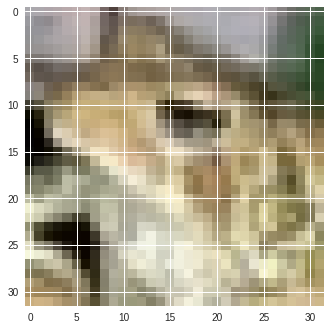

In [0]:
imshow(small_testset[0][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[0].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[0].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[0].item()])

Default Model Predicted Label:  bird
Model1 Predicted Label:  bird
Model2 Predicted Label:  bird


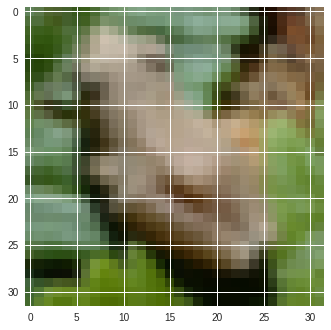

In [0]:
imshow(small_testset[1][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[1].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[1].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[1].item()])

Default Model Predicted Label:  deer
Model1 Predicted Label:  deer
Model2 Predicted Label:  deer


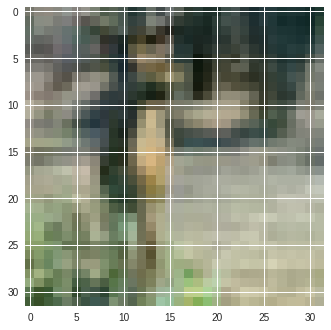

In [0]:
imshow(small_testset[2][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[2].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[2].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[2].item()])

Default Model Predicted Label:  ship
Model1 Predicted Label:  ship
Model2 Predicted Label:  car


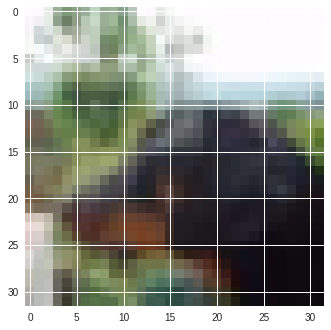

In [0]:
imshow(small_testset[3][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[3].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[3].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[3].item()])

Default Model Predicted Label:  truck
Model1 Predicted Label:  dog
Model2 Predicted Label:  dog


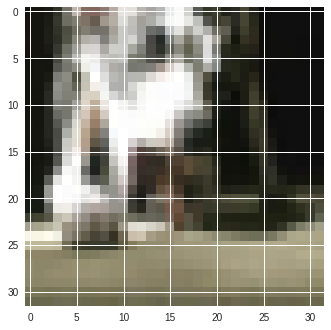

In [0]:
imshow(small_testset[4][0]) # displays test image number 0
print("Default Model Predicted Label: ", real_labels[predictions[4].item()])
print("Model1 Predicted Label: ", real_labels[predictions1[4].item()])
print("Model2 Predicted Label: ", real_labels[predictions2[4].item()])